In [25]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML('<style>.container { width:97% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import load_data as ld
import embedder_generator as gen
import embedder
import utilities as ut

from sklearn.model_selection import train_test_split


import keras.backend as K
from my_callbacks import MyCallback_sinusoidal
from sklearn.preprocessing import Normalizer

import umap

import numpy as np

In [27]:
#name = "generate_graphs/125_pos_neg_BALANCED(2038)" #Leukemia
#name = "generate_graphs/489028_pos_neg_BALANCED(2864)" #Cancer
#name = "generate_graphs/1111_pos_neg_BALANCED" # AIDS
#name = "generate_graphs/2222_pos_neg_(BALANCED)" # PROTEINS
name = "generate_graphs/3333_pos_neg_(BALANCED)" # DHFR

In [28]:
# load data 
graphs,labels = ld.load_data_pubchem(name)

# add vectorize vertex 8 bit
graphs = ut.add_info_to_nodes(graphs,ut.vec_vertex,8)
max_n_nodes, n_attributes = ut.find_shapes(graphs)
print("n_ attributes: "+str(n_attributes))

#split train test
graphs_train, graphs_test, labels_train, labels_test = train_test_split(graphs, labels, test_size=0.2, random_state=42)

n_ attributes: 261


In [31]:
times_repeat_spk = 1
# build model spketral
spk_cla,spk_emb = gen.gen_SpektralGNN_emb(n_classes=2,
                                            max_n_nodes = max_n_nodes,
                                            n_attributes = n_attributes,
                                            n_components= 128)
emb_spk = embedder.Kernel_GNN(classificator = spk_cla,
                              embedder = spk_emb,
                              batch_size = 32,
                              validation_split = 0.2,
                              epochs = 200,
                              patience = 15,
                              callbacks=None,
                              verbose=0)

# fit spk
emb_spk.fit(graphs_train,labels_train)
# transfrom train and test to n_componentes = 128
X_train = emb_spk.transform(graphs_train)
X_test = emb_spk.transform(graphs_test)
ut.evaluate_emb_train_test(X_test,labels_test,X_train,labels_train)
tes,_=list(ut.evaluate_emb_train_test(X_test,labels_test,X_train,labels_train,return_value=True))
tes = float(tes)

Stopped epoch:  45
DIM: 128            TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.991    0.989


In [32]:
X_train_128 = emb_spk.transform(graphs_train)
X_test_128 = emb_spk.transform(graphs_test)
ut.evaluate_emb_train_test(X_test_128,labels_test,X_train_128,labels_train)

DIM: 128            TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.991    0.989


# From 128 to 32

In [33]:
from keras.callbacks import TensorBoard
from datetime import datetime
from keras.callbacks import EarlyStopping

In [34]:
for i in range(1):

    w_dec = K.variable(1)
    w_cla = K.variable(1)
    input_auto = len(X_train_128[0])
    auto_epochs = 100
    auto_plateau = 10
    auto_k = 1
    auto_n_period = 4

    auto_scale_d = 1
    auto_scale_c = 0.01

    auto1, enc1 = gen.gen_sup_auto_callback(w_dec,w_cla,input_auto,embedding_size=32,n_classes=2)
    # CALLBACK  
    my_call_sin1 = MyCallback_sinusoidal(w_dec, w_cla, auto_epochs,auto_plateau,auto_k,auto_n_period,auto_scale_c,auto_scale_d)
    # SCALER
    scal1 = embedder.Preprocessing_scaler([0, 1])    
    # NORMALIZER
    #norm1 = Normalizer(copy=True, norm='l2')

    emb_auto1 = embedder.Transformer_sup_autoencoder(autoencoder = auto1,
                                                     encoder = enc1,
                                                     batch_size = 32,
                                                     validation_split = 0.2,
                                                     epochs = auto_epochs,
                                                     callbacks = [my_call_sin1], #[my_call_sin1],
                                                     verbose = 0,
                                                     normal = None,
                                                     scaler = scal1)

    # fit
    emb_auto1.fit(X_train_128,labels_train)
    # transform
    X_train_32 = emb_auto1.transform(X_train_128)
    X_test_32 = emb_auto1.transform(X_test_128)
    # evaluate
    ut.evaluate_emb_train_test(X_test_32,labels_test,X_train_32,labels_train)

DIM: 32             TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy       1    0.994


DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.983    0.996


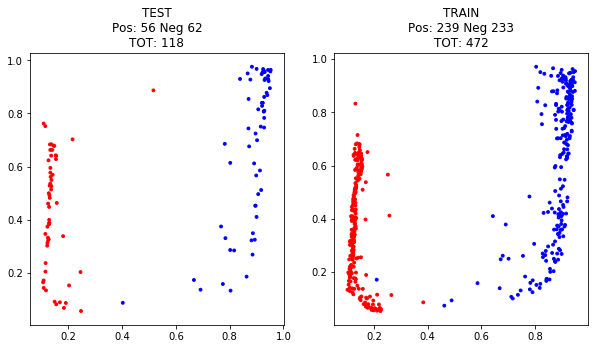

In [35]:
for i in range(1):
    uma_dnn = gen.gen_umap_dnn(auto_n_components = 32, emb_n_components = 2, dnn_epochs = 100,dnn_batch_size = 32)
    uma_dnn.fit(X_train_32,labels_train)

    X_train_2 = uma_dnn.transform(X_train_32)
    X_test_2 = uma_dnn.transform(X_test_32)
    
    ut.evaluate_emb_train_test(X_test_2,labels_test,X_train_2,labels_train)
    plot2d_tmp(X_test_2,labels_test,X_train_2,labels_train)


In [36]:
to_save = [graphs_test,graphs_train,X_test_128,X_train_128,X_test_32,X_train_32,X_test_2,X_train_2,labels_test,labels_train]

In [37]:
np.save("grafi_128_32_2_lab_test_train_dhfr",to_save)

In [18]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
def plot2d_tmp(res_test,y_test,res_train,y_train):
    _,[pos_tra,neg_tra] = np.unique(y_train,return_counts=True)
    _,[pos_tes,neg_tes] = np.unique(y_test,return_counts=True)

    colors = ['red','blue']
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    x = res_test[:,0]
    y = res_test[:,1]
    plt.title("TEST\nPos: "+str(pos_tes)+" Neg "+str(neg_tes)+"\nTOT: "+str(len(y_test)))
    plt.scatter(x,y,s=8,c=y_test,cmap=matplotlib.colors.ListedColormap(colors))


    plt.subplot(122)
    x = res_train[:,0]
    y = res_train[:,1]
    plt.title("TRAIN\nPos: "+str(pos_tra)+" Neg "+str(neg_tra)+"\nTOT: "+str(len(y_train)))
    plt.scatter(x,y,s=8,c=y_train,cmap=matplotlib.colors.ListedColormap(colors))

    plt.show()
    